In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, log_loss, accuracy_score, recall_score, precision_score, f1_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# !unzip Lab6-zad1.zip
#wczytanie danych
X = np.load('padded_features_bin.npy') #macierz cech - jednej wiersz = jeden obiekt
y = np.load('labels_bin.npy') #etykiety

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42) #podział na zbiory

## Regresja logistyczna

Oprócz modeli klasyfikacyjnych, w uczeniu maszynowym często wykorzystywane są modele regresyjne - służą do przewidywania wartości zmiennej na podstawie danych. Modele regresyjne różnią się od modeli klasyfikacyjnych przede wszystkim tym, co uzyskujemy na wyjściu. Klasyfikatory zwracają przewidywaną przynależność obiektu do klasy, czyli liczbę całkowitą. Natomiast modele regresyjne (regresory) zwracają wartości ciągłe - może, ale nie musi to być liczba całkowita. Wyniki nie mogą być traktowane bezpośrednio jako przynależność do klas - jeżeli chcemy je do tego wykorzystać, konieczne jest przetworzenie wyników. Będziemy to robić w zadaniu 1.

Regresja logistyczna prognozuje prawdopodobieństwo wystąpienia zjawiska jako funkcję zmiennych niezależnych. Prawdopodobieństwo to jest opisane tzw. funkcją logistyczną (rodzajem funkcji sigmoidalnej) - stąd nazwa regresji. W kontekście klasyfikacji można powiedzieć, że regresja logistyczna prognozuje prawdopodobieństwo przynależności obiektu do danej klasy.

In [4]:
scaler = StandardScaler().fit(X_train) #standaryzacja
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_reg = LogisticRegression(random_state=42)
lr_reg.fit(X_train_scaled, y_train)
preds_test = lr_reg.predict(X_test_scaled)
preds_train = lr_reg.predict(X_train_scaled)

## Logarytmiczna funkcja straty - *log loss*

Skoro otrzymujemy wartości ciągłe, potrzebujemy innej niż do tej pory (macierz pomyłek i metryki) metody oceny jakości modelu. Możemy wykorzystać logarytmiczną funkcję straty (*log loss*,  inaczej *cross-entropy loss*). Oblicza się ją jako ujemną średnią logarytmiczną skorygowanych prawdopodobieństw.

W przypadku klasyfikacji binarnej, na wyjściu regresora otrzymujemy prawdopodobieństwo przynależności obiektu do klasy pozytywnej (1). Wobec tego:

- jeżeli obiekt należy do klasy 1, to prawdopodobieństwo skorygowane wynosi tyle, ile wyznaczone przez regresor (`pred`),

- jeżeli obiekt należy do klasy 0, to prawdopodobieństwo skorygowane wynosi `1-pred`.

Ponieważ prawdopodobieństwo przyjmuje wartości z przedziału [0,1], to jego logarytm będzie miał wartość ujemną. Dlatego po policzeniu średniej z logarytmów mnożymy ją przez -1, żeby uzyskać stratę logarytmiczną o wartości dodatniej. To upraszcza interpretację: im mniejsza strata logarytmiczna, tym predykcje modelu bliższe są wartości rzeczywistej.

In [5]:
print(log_loss(y_test, preds_test))

0.7751323309487561


Dla porównania możemy to policzyć ręcznie zgodnie z algorytmem opisanym powyżej.

*Uwaga:* ponieważ dla 0 i 1 funkcja jest niezdefiniowana, musimy ograniczyć prawodpodobieństwa do zakresu `[eps, 1-eps]`, gdzie `eps` to precyzja naszej reprezentacji liczb.

In [6]:
corrected_prob = []
for y_pred, y_true in zip(preds_test, y_test):
    eps = np.finfo(np.float64).eps # = 2.2204460492503131e-16
    y_pred = max(eps, min(1 - eps, y_pred))
    if y_true == 0:
        corrected_prob.append(1-y_pred)
    else:
        corrected_prob.append(y_pred)
        
corrected_prob = np.array(corrected_prob)
log_prob = np.log(corrected_prob)
logloss = -(np.mean(log_prob))
print(logloss)

0.7751323309487561


# Krzywa ROC, metryka ROC AUC

Oprócz straty logarytmicznej do oceny jakości regresora w klasyfikacji binarnej używa się często metryki ROC AUC, czyli pola pod krzywą ROC (AUC=*area under curve*).

Krzywa ROC (*receiver operating characteristic*) przedstawia zdolności diagnostyczne modelu w zależności od przyjętego progu dyskryminacyjnego. Na osi X jest FPR (1-specyficzność), a na osi Y TPR (czułość).

In [7]:
def plot_roc_curve(y, preds, thr_gmean: tuple=None, image_path=None):

    fpr, tpr, thresholds = roc_curve(y, preds)
    plt.plot([0,1], [0,1], linestyle='--', label='Chance level')
    plt.plot([0, 0, 1], [0, 1, 1], 'k--', label='Perfect model')
    plt.plot(fpr, tpr, marker='.', label='Evaluated model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if thr_gmean is not None:
        plt.scatter(thr_gmean[0], thr_gmean[1], marker='o', color='black', label='Best g-mean')
    plt.legend()
    if image_path is not None:
        plt.savefig(image_path, dpi = 300)   # save the figure to file

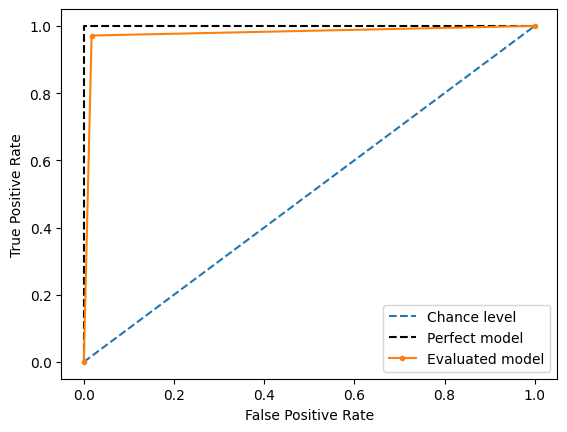

In [8]:
plot_roc_curve(y_test, preds_test)

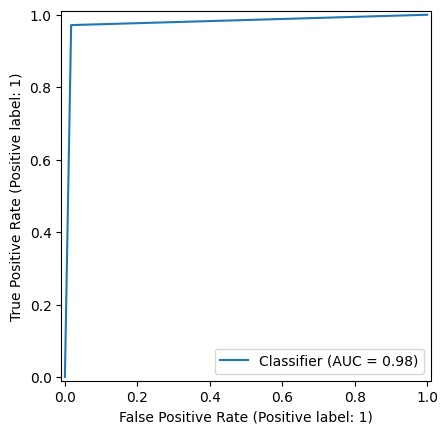

In [9]:
RocCurveDisplay.from_predictions(y_test, preds_test)

W idealnym przypadku krzywa ROC powinna rosnąć od 0 do 1 w punkcie `x=0`, a następnie przebiegać równolegle do osi X ROC AUC wynosi wówczas 1. Im bardziej uzyskana krzywa różni się od takiego przebiegu, tym gorszy model.

Jeśli ROC AUC wynosi 0,5, a krzywa ROC leży na linii `y=x`, to model nie nadaje się do użytku - prawdopodobieństwo przynależności do klasy 0 wynosi 0,5, do klasy 1 również 0,5, więc równie dobrze mógłby dokonywać predykcji w sposób losowy.

Uzyskanie `ROC AUC = 1` jest w przypadku danych rzeczywistych mało realne - dążymy jednak do tego, by jego wartość była jak największa.

In [10]:
print('test ROC AUC: ', roc_auc_score(y_test, preds_test))

test ROC AUC:  0.9770935960591133
